## Caching
Reference: https://www.youtube.com/watch?v=FujwRYkBwM4&list=PLWAuYt0wgRcLCtWzUxNg4BjnYlCZNEVth&index=8

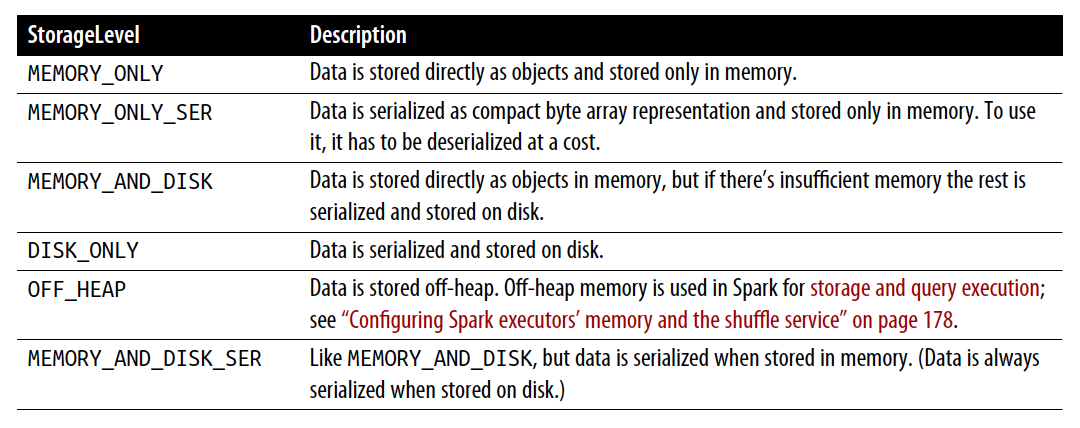

In [3]:
from IPython.display import Image
Image(filename='../UI_screenshots/caching/cachinglevels.png',width=500,height=5)

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
# Initialize Spark Session
spark = SparkSession.builder.appName("caching").getOrCreate()
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/12 16:26:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
cust_df = spark.read.parquet('../data/customers.parquet')
cust_df.show(10)

+----------+-------------+---+------+----------+-----+------------+
|   cust_id|         name|age|gender|  birthday|  zip|        city|
+----------+-------------+---+------+----------+-----+------------+
|C007YEYTX9| Aaron Abbott| 34|Female| 7/13/1991|97823|      boston|
|C00B971T1J| Aaron Austin| 37|Female|12/16/2004|30332|     chicago|
|C00WRSJF1Q| Aaron Barnes| 29|Female| 3/11/1977|23451|      denver|
|C01AZWQMF3|Aaron Barrett| 31|  Male|  7/9/1998|46613| los_angeles|
|C01BKUFRHA| Aaron Becker| 54|  Male|11/24/1979|40284|   san_diego|
|C01RGUNJV9|   Aaron Bell| 24|Female| 8/16/1968|86331|      denver|
|C01USDV4EE|  Aaron Blair| 35|Female|  9/9/1974|80078|    new_york|
|C01WMZQ7PN|  Aaron Brady| 51|Female| 8/20/1994|52204|philadelphia|
|C021567NJZ| Aaron Briggs| 57|  Male| 3/10/1990|22008|philadelphia|
|C023M6MKR3|  Aaron Bryan| 29|  Male| 4/10/1976|05915|philadelphia|
+----------+-------------+---+------+----------+-----+------------+
only showing top 10 rows



In [6]:
base_df = cust_df.where(col('city')=='boston')\
    .withColumn('customer_group',\
                when(col('age').between(20,30),lit('Young'))\
                    .when(col('age').between(31,50),lit('mid'))\
                        .when(col('age')>51, lit('Old')).otherwise(lit('Kid')))\
                        .select("cust_id", "name", "age", "gender", "birthday", "zip", "city", "customer_group")

base_df.show(10)

+----------+---------------+---+------+---------+-----+------+--------------+
|   cust_id|           name|age|gender| birthday|  zip|  city|customer_group|
+----------+---------------+---+------+---------+-----+------+--------------+
|C007YEYTX9|   Aaron Abbott| 34|Female|7/13/1991|97823|boston|           mid|
|C08XAQUY73|  Aaron Lambert| 54|Female|11/5/1966|75218|boston|           Old|
|C094P1VXF9|  Aaron Lindsey| 24|  Male|9/21/1990|29399|boston|         Young|
|C097SHE1EF|    Aaron Lopez| 22|Female|4/18/2001|82129|boston|         Young|
|C0DTC6436T| Aaron Schwartz| 52|Female| 7/9/1962|57192|boston|           Old|
|C0R42FPHRH|    Abbie Reyes| 63|  Male|10/8/1995|31557|boston|           Old|
|C0RZV4BH7T|Abbie Stevenson| 36|  Male|2/10/1971|46909|boston|           mid|
|C0U9RV3VBE|    Ada Andrews| 42|  Male|6/10/1961|79039|boston|           mid|
|C0XNANAD6L|     Ada Harper| 52|  Male|4/16/1996|70515|boston|           Old|
|C1869HFVF8|     Adam Clark| 30|Female|7/17/1972|65664|boston|  

Without caching

In [7]:
df1 = (
    base_df
    .withColumn("test_column_1", lit("test_column_1"))
    .withColumn("birth_year", split("birthday", "/").getItem(2))
)

df1.explain(True)
df1.show(5, False)

== Parsed Logical Plan ==
'Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, customer_group#44, test_column_1#94, split('birthday, /, -1)[2] AS birth_year#104]
+- Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, customer_group#44, test_column_1 AS test_column_1#94]
   +- Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, customer_group#44]
      +- Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, CASE WHEN ((cast(age#2 as int) >= 20) AND (cast(age#2 as int) <= 30)) THEN Young WHEN ((cast(age#2 as int) >= 31) AND (cast(age#2 as int) <= 50)) THEN mid WHEN (cast(age#2 as int) > 51) THEN Old ELSE Kid END AS customer_group#44]
         +- Filter (city#6 = boston)
            +- Relation [cust_id#0,name#1,age#2,gender#3,birthday#4,zip#5,city#6] parquet

== Analyzed Logical Plan ==
cust_id: string, name: string, age: string, gender: string, birthday: string, zip: string, city: string, customer_group: stri

In [9]:
df2 = (
    base_df
    .withColumn("test_column_2", lit("test_column_2"))
    .withColumn("birth_month", split("birthday", "/").getItem(1))
)

df2.explain(True)
df2.show(5, False)

== Parsed Logical Plan ==
'Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, customer_group#44, test_column_2#156, split('birthday, /, -1)[1] AS birth_month#166]
+- Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, customer_group#44, test_column_2 AS test_column_2#156]
   +- Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, customer_group#44]
      +- Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, CASE WHEN ((cast(age#2 as int) >= 20) AND (cast(age#2 as int) <= 30)) THEN Young WHEN ((cast(age#2 as int) >= 31) AND (cast(age#2 as int) <= 50)) THEN mid WHEN (cast(age#2 as int) > 51) THEN Old ELSE Kid END AS customer_group#44]
         +- Filter (city#6 = boston)
            +- Relation [cust_id#0,name#1,age#2,gender#3,birthday#4,zip#5,city#6] parquet

== Analyzed Logical Plan ==
cust_id: string, name: string, age: string, gender: string, birthday: string, zip: string, city: string, customer_group: s

After caching

In [10]:
base_df.cache()
base_df.show(10)

+----------+---------------+---+------+---------+-----+------+--------------+
|   cust_id|           name|age|gender| birthday|  zip|  city|customer_group|
+----------+---------------+---+------+---------+-----+------+--------------+
|C007YEYTX9|   Aaron Abbott| 34|Female|7/13/1991|97823|boston|           mid|
|C08XAQUY73|  Aaron Lambert| 54|Female|11/5/1966|75218|boston|           Old|
|C094P1VXF9|  Aaron Lindsey| 24|  Male|9/21/1990|29399|boston|         Young|
|C097SHE1EF|    Aaron Lopez| 22|Female|4/18/2001|82129|boston|         Young|
|C0DTC6436T| Aaron Schwartz| 52|Female| 7/9/1962|57192|boston|           Old|
|C0R42FPHRH|    Abbie Reyes| 63|  Male|10/8/1995|31557|boston|           Old|
|C0RZV4BH7T|Abbie Stevenson| 36|  Male|2/10/1971|46909|boston|           mid|
|C0U9RV3VBE|    Ada Andrews| 42|  Male|6/10/1961|79039|boston|           mid|
|C0XNANAD6L|     Ada Harper| 52|  Male|4/16/1996|70515|boston|           Old|
|C1869HFVF8|     Adam Clark| 30|Female|7/17/1972|65664|boston|  

In [11]:
df1 = (
    base_df
    .withColumn("test_column_1", lit("test_column_1"))
    .withColumn("birth_year", split("birthday", "/").getItem(2))
)

df1.explain(True)
df1.show(5, False)

== Parsed Logical Plan ==
'Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, customer_group#44, test_column_1#451, split('birthday, /, -1)[2] AS birth_year#461]
+- Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, customer_group#44, test_column_1 AS test_column_1#451]
   +- Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, customer_group#44]
      +- Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, CASE WHEN ((cast(age#2 as int) >= 20) AND (cast(age#2 as int) <= 30)) THEN Young WHEN ((cast(age#2 as int) >= 31) AND (cast(age#2 as int) <= 50)) THEN mid WHEN (cast(age#2 as int) > 51) THEN Old ELSE Kid END AS customer_group#44]
         +- Filter (city#6 = boston)
            +- Relation [cust_id#0,name#1,age#2,gender#3,birthday#4,zip#5,city#6] parquet

== Analyzed Logical Plan ==
cust_id: string, name: string, age: string, gender: string, birthday: string, zip: string, city: string, customer_group: st

In [12]:
df2 = (
    base_df
    .withColumn("test_column_2", lit("test_column_2"))
    .withColumn("birth_month", split("birthday", "/").getItem(1))
)

df2.explain(True)
df2.show(5, False)

== Parsed Logical Plan ==
'Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, customer_group#44, test_column_2#793, split('birthday, /, -1)[1] AS birth_month#803]
+- Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, customer_group#44, test_column_2 AS test_column_2#793]
   +- Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, customer_group#44]
      +- Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, CASE WHEN ((cast(age#2 as int) >= 20) AND (cast(age#2 as int) <= 30)) THEN Young WHEN ((cast(age#2 as int) >= 31) AND (cast(age#2 as int) <= 50)) THEN mid WHEN (cast(age#2 as int) > 51) THEN Old ELSE Kid END AS customer_group#44]
         +- Filter (city#6 = boston)
            +- Relation [cust_id#0,name#1,age#2,gender#3,birthday#4,zip#5,city#6] parquet

== Analyzed Logical Plan ==
cust_id: string, name: string, age: string, gender: string, birthday: string, zip: string, city: string, customer_group: s

In [13]:
spark.stop()